<a href="https://colab.research.google.com/github/Pratichhya/ubs_course/blob/main/Simple%20Linear%20regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical Lab: Linear Regression by using the gradient descent algorithm

## Utils

In [2]:
#import libraries 

from sklearn import datasets # donnees/ available dataset in sklearn library
import os # rep de travail
import pandas as pd # data analysis
from scipy import stats # stat desc
import matplotlib.pyplot as plt # graphiques
import numpy as np # maths
import seaborn as sns

## Data

In [3]:
#-- Reading the (training) data in a data frame 
dataset=pd.read_csv('/content/drive/MyDrive/ubs/machine learning/pm25_train_data.csv',sep=';')
dataset=dataset.dropna()          # dropping the null values

In [4]:
#-- Save the explanatory variables in a variable X (and their names in a varaible feature_names), and the target variable in Y
x=dataset[["SO2","NO2","O3","CO","dew point","pressure","rainfall","temperature"]]
y= dataset["PM2.5"]

### Analyser et sélectionner les données étudiées

In [5]:
#-- Display some statistics on the data by using the describe function on the dataframe
x.describe()

,SO2,NO2,O3,CO,dew point,pressure,rainfall,temperature
count,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000,11160.000000
mean,21.803471,44.614596,74.123981,1165.918100,2.826747,1009.810802,0.046918,17.943513
std,26.880259,32.895568,51.904421,1010.439512,13.450111,10.075603,0.535652,10.751609
min,0.856800,2.000000,0.214200,100.000000,-31.300000,984.500000,0.000000,-6.800000
25%,4.000000,19.000000,34.000000,500.000000,-8.200000,1001.800000,0.000000,8.200000
50%,12.000000,36.000000,66.000000,900.000000,3.100000,1009.300000,0.000000,20.000000
75%,28.000000,62.000000,103.000000,1500.000000,15.000000,1017.600000,0.000000,27.400000
max,224.000000,273.000000,345.000000,10000.000000,28.500000,1036.300000,31.200000,39.800000


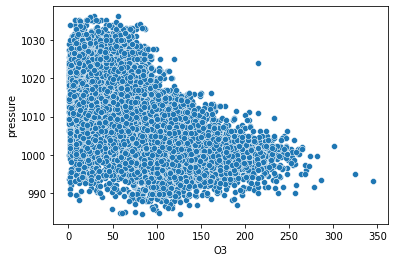

In [6]:
#-- Scatterplots for each explanatory variable
sns.scatterplot(data=dataset, x="O3", y="pressure")

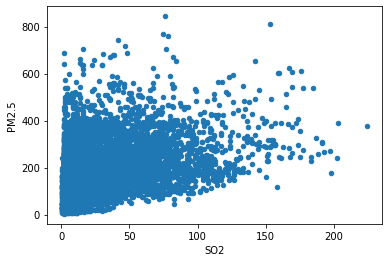

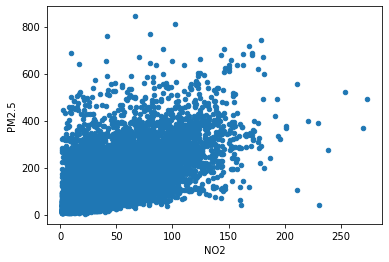

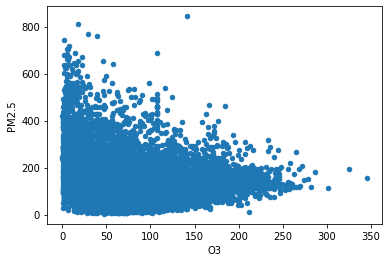

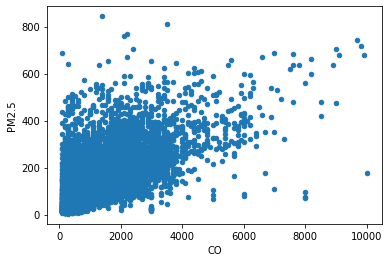

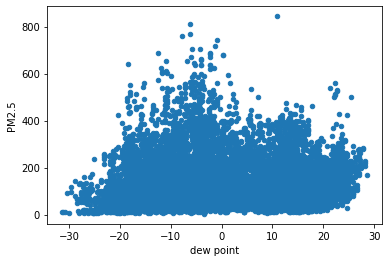

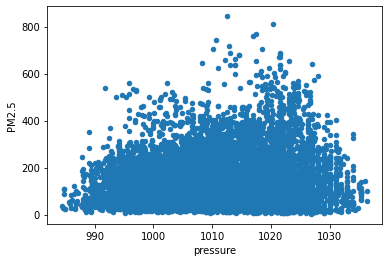

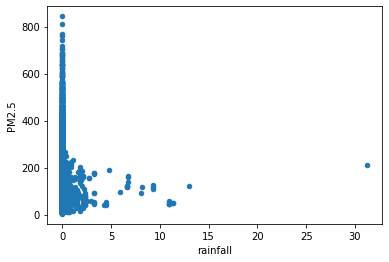

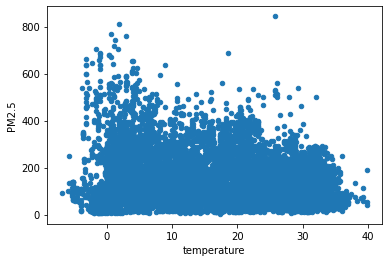

In [7]:
#plotting PM2.5 across other columns
for i in x.columns:
  dataset.plot.scatter(x=i, y="PM2.5")

In [8]:
#checking the correlation among the values. Also it was not much clear for me in scatter plot as the number of data points was huge
dataset.corr()

,PM2.5,SO2,NO2,CO,O3,temperature,pressure,dew point,rainfall,windspeed
PM2.5,1.000000,0.485462,0.572813,0.636648,-0.218340,-0.246685,0.140336,-0.029720,-0.037032,-0.187595
SO2,0.485462,1.000000,0.598753,0.630310,-0.287325,-0.366533,0.231831,-0.242011,-0.041511,-0.163247
NO2,0.572813,0.598753,1.000000,0.744382,-0.417748,-0.217173,0.146548,0.014724,-0.009562,-0.347697
CO,0.636648,0.630310,0.744382,1.000000,-0.323917,-0.273665,0.139458,0.041599,0.022054,-0.313852
O3,-0.218340,-0.287325,-0.417748,-0.323917,1.000000,0.683293,-0.555046,0.459740,-0.030031,0.100689
temperature,-0.246685,-0.366533,-0.217173,-0.273665,0.683293,1.000000,-0.811459,0.810234,-0.001144,-0.093390
pressure,0.140336,0.231831,0.146548,0.139458,-0.555046,-0.811459,1.000000,-0.716093,-0.030913,0.062114
dew point,-0.029720,-0.242011,0.014724,0.041599,0.459740,0.810234,-0.716093,1.000000,0.087952,-0.350106
rainfall,-0.037032,-0.041511,-0.009562,0.022054,-0.030031,-0.001144,-0.030913,0.087952,1.000000,-0.035374
windspeed,-0.187595,-0.163247,-0.347697,-0.313852,0.100689,-0.093390,0.062114,-0.350106,-0.035374,1.000000


### so above table shows there is comparative correlation of PM2.5 with SO2, NO2 and CO

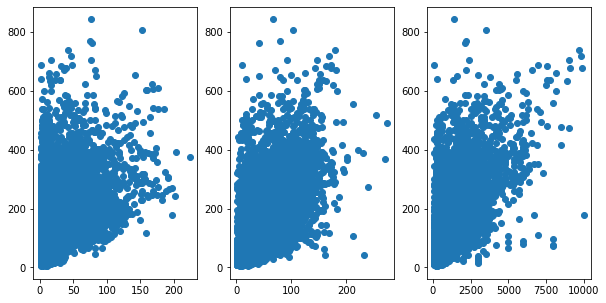

In [9]:
#-- Select the explanatory variables for the simple linear regression, then the multiple linear regression, and display the scatter plots
plt.figure(figsize=(10,5))
plt.subplot(131).scatter(x["SO2"], y)
plt.subplot(132).scatter(x["NO2"], y)
plt.subplot(133).scatter(x["CO"], y)
plt.show()



In [10]:
#-- Extract the data and creates two X matrices that will be used for the regression (have a look at page 26 to know the form of X):
#---- Xs for simple lin reg and Xm for multiple lin reg
Xs=x['NO2'].values      # though CO showed highest correlation with PM2.5, and the second one was with NO2 and since my other collegues were doing for CO I chose to do with NO2
Xm=x[['SO2','NO2','CO']].values

#-- Check the size of both matrices
print(Xs.shape)
print(Xm.shape)

(11160,)
(11160, 3)


In [11]:
#--- Write the standardisation function to mean-center the X data
def standardisation(x):
  #check dimension:
  mean=np.mean(x, axis=0)
  std=np.std(x, axis=0, ddof=1)       #we have kept ddof=1 as it is for sample data else in case of python they have kept default to 0 as for population data
  n=((x-mean)/std)                    # based on the equation((mean-x)/standard deviation)
  return n


Xs_norm=standardisation(Xs)           #calling function for simple linear function
Xm_norm=standardisation(Xm)           #calling function for multiple linear function
print(stats.describe(Xs_norm))

DescribeResult(nobs=11160, minmax=(-1.2954509772228051, 6.942740758380764), mean=-2.0373985254769898e-17, variance=1.0, skewness=1.2515904447537654, kurtosis=1.9889191890624716)


In [12]:
#create a table with value ones
print(Xs_norm.shape)
z = np.ones((11160, 1))

(11160,)


In [13]:
#-- Preparing the matrix used for the regression linear when using the gradient descent algorithm (add 1 vector column)
Xs_final=np.column_stack((z,Xs_norm))         #adding ones in the index 0 to the value of x
Xm_final=np.column_stack((z,Xm_norm))
Xs_final

array([[ 1.        , -0.96105943],
       [ 1.        ,  0.95409215],
       [ 1.        ,  1.65327448],
       ...,
       [ 1.        ,  1.65327448],
       [ 1.        , -0.90026097],
       [ 1.        ,  0.28530906]])

## Least squares or maximum likelihood solution

In [16]:
Y=y.to_numpy()         # changing pandas dataframe to numpy array for simplicity

In [27]:
#-- To compare the results of the gradient descent algorithm, we will first implement an exact solution with the maximum likelihood
#Formulae recall: (X^T X)^-1 X^T Y
def coef_ml(x,y):
  m = np.dot(x.T, x)
  inv = np.linalg.inv(m)
  n = np.dot(x.T, y)
  beta = np.dot(inv,n)
  return beta
  
  
Xs_B = coef_ml(Xs_final,Y)
Xm_B = coef_ml(Xm_final,Y)

print("Beta parameters for simple linear regression:", Xs_B)
print("Beta parameters for multiple linear regression:", Xm_B)


Beta parameters for simple linear regression: [144.78560932  58.95773491]
Beta parameters for multiple linear regression: [144.78560932  10.09815632  19.89592831  44.35291959]


## Gradient descent algorithm

In the following we will implement several functions to apply linear regression.
These functions should be generic and work for any number of explanatory varaibles. You should be able to apply them to Xs and Xm standardized variables.

WARNING: parameters of the functions needs to be completed

In [28]:
#-- Model
def f(x,b):
  return np.dot(x,b)            #f(x)=B0+B1X1+B2X2+B3X3

Xs_func= f(Xs_final,Xs_B)       #function call for simple regression
Xm_func= f(Xm_final,Xm_B)       #function call for multiple regression
Xm_func

array([ 82.09399419, 153.29661435, 217.46870806, ..., 267.27543366,
        92.08257216, 148.27522406])

In [29]:
#%% Cost function
def cout(x,y,beta):
  m= y.shape[0]
  JB=np.sum((np.square(f(x,beta)-Y)))/(2*m)
  #JB=(np.square(g-y))/(2*m)
  return JB

print("Cost function for simple linear regression: ",cout(Xs_final,Y,Xs_B))           #function call for simple regression
print("Cost function for multiple linear regression: ",cout(Xm_final,Y,Xm_B))         #function call for multiple regression

Cost function for simple linear regression:  3558.630618377038
Cost function for multiple linear regression:  3004.7105796697406


In [30]:
#%% Computation of the gradient
def grad(x,y,beta):
    m = x.shape[0]
    return 1/m * np.dot(f(x,beta)-y,x)                                #(d(J(B))/d(B)) i.e 1/m((f-y).x)


print("Grad for simple linear regression:", grad(Xs_final,Y,Xs_B))    #function call for simple regression
print("Grad for simple linear regression:", grad(Xm_final,Y,Xm_B))    #function call for multiple regression

Grad for simple linear regression: [-7.66061846e-15  6.36483299e-14]
Grad for simple linear regression: [-1.94775299e-14 -2.65269288e-14  2.95830266e-14  3.38411895e-14]


In [32]:
#gradient descent algorithm
def grad_descent(x,y,beta,alpha,itre):
  iter_shape=x.shape[1]                                     #size of observations
  beta_val=np.zeros((itre,iter_shape))                      #list to store the beta values and cost values
  cost_val=[]

  #calculate the beta values for each iteration
  for i in range(itre):
    beta=beta-alpha*grad(x,y,beta)                          #B(k)=B(k-1)-learning_rater*derivative of cost function i.e grad 
    beta_val[i,:]=beta                                      #update beta value
    cost=cout(x,y,beta)                                     #call the cost function for different beta values over iteration
    if len(cost_val)>2 and cost_val[-1]-cost<0.001:         #condition implemented for breakdown of the loop
      break
    cost_val.append(cost)
  return beta, beta_val, cost_val


## Experiment with several initialisations: visualisation of the cost function and parameter values during the iterations

for simple linear regression:  [143.80509675  58.56470029]


Text(0.5, 1.0, 'Cost vs Iterations Analysis')

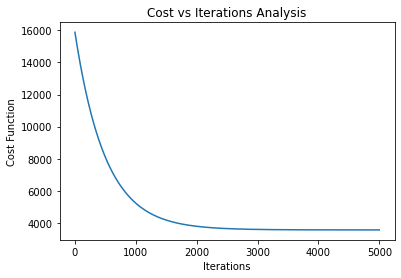

In [34]:
beta_shape=Xs_final.shape[1]
alpha = 0.001                                                   # Learning Rate
iter=5000                                                       #number of iteration tested on

beta=np.random.randn(beta_shape,)                               #initializing randome values
#calling gradient descent function
beta,beta_val,cost_val= grad_descent(Xs_final,Y,beta,alpha,iter)      #calling gradient descent function for simple linear regression
optimum_value=beta_val[len(cost_val)-1]
print("for simple linear regression: ",optimum_value)
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val)),cost_val)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost vs Iterations Analysis')

for multiple linear regression:  [143.81246314  12.05693361  22.66729076  39.80576244]


Text(0.5, 1.0, 'Cost vs Iterations Analysis')

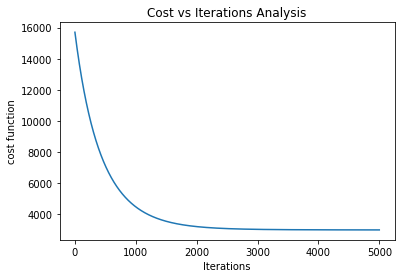

In [35]:
beta_shape=Xm_final.shape[1]
alpha = 0.001                                                     # Learning Rate
iter=5000                                                         # Number of iterations

beta=np.random.randn(beta_shape,)                                  # Initializing random values
beta_m,betaval_m,cost_val_m= grad_descent(Xm_final,Y,beta,alpha,iter)        #calling gradient descent function       
optimum_value_m=betaval_m[len(cost_val_m)-1]
print("for multiple linear regression: ",optimum_value_m)
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val_m)),cost_val_m)
plt.xlabel('Iterations')
plt.ylabel('cost function')
plt.title('Cost vs Iterations Analysis')


## Experiment with several learning rates: visualisation of the cost function and parameter values during the iterations

for simple linear regression:  [144.49269285  58.83861288]


Text(0.5, 1.0, 'Analysis when value of learning rate is increased')

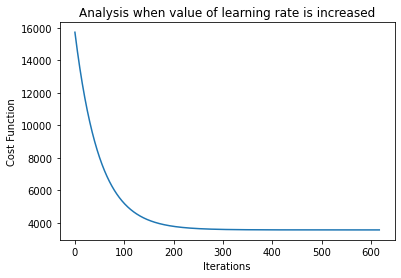

In [41]:
beta_shape=Xs_final.shape[1]
alpha = 0.01                                                   # Learning Rate
iter=5000                                                       #number of iteration tested on

beta=np.random.randn(beta_shape,)                               #initializing randome values
#calling gradient descent function
beta,beta_val,cost_val= grad_descent(Xs_final,Y,beta,alpha,iter)      #calling gradient descent function for simple linear regression
optimum_value=beta_val[len(cost_val)-1]
print("for simple linear regression: ",optimum_value)
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val)),cost_val)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Analysis when value of learning rate is increased')

for simple linear regression:  [8.29605442 3.78434147]


Text(0.5, 1.0, 'Analysis when value of learning rate is decreased')

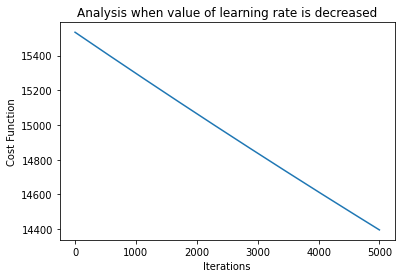

In [43]:
beta_shape=Xs_final.shape[1]
alpha = 0.00001                                                   # Learning Rate
iter=5000                                                       #number of iteration tested on

beta=np.random.randn(beta_shape,)                               #initializing randome values
#calling gradient descent function
beta,beta_val,cost_val= grad_descent(Xs_final,Y,beta,alpha,iter)      #calling gradient descent function for simple linear regression
optimum_value=beta_val[len(cost_val)-1]
print("for simple linear regression: ",optimum_value)
# Plotting Line Plot for Number of Iterations vs MSE
plt.plot(range(len(cost_val)),cost_val)
plt.xlabel('Iterations')
plt.ylabel('Cost Function')
plt.title('Cost vs Iterations Analysis')
plt.title('Analysis when value of learning rate is decreased')

**Notes:**
It was notes that when learning rate was increased though it took considerably more time but finer result was achieved. Whereas, when learning rate was decrease, the value quickly jumped to another resulting a straight line.

## Notes
**on the choice of the stopping criterion:**
Our goal here is to minimize the cost function in a way that it comes as close to zero as possible.




**on the data normalisation:**
Before starting the process for linear regression using gradient descent the dataset was normalized and we did it taking into consideration idea of standardization. By diving the difference of mean and value of x by its standard deviation, the data was normalized which was then generalized by adding a fixed columns of ones to each table so that the intercept values are preserved.
